In [1]:
from tensorflow_probability import distributions as tfd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import statsmodels.api as sm
import pickle
from sklearn.feature_selection import mutual_info_regression
from scipy import stats

In [2]:
#defining the class MDN
class MDN_module(tf.keras.Model):
    def __init__(self, neurons=15, components = 1):
        super(MDN_module, self).__init__(name="MDN_module")
        self.neurons = neurons
        self.components = components

        #chaging activation to relu from linear, changin relu to sigmoid 
        for i in range(1,3):
          s="self"+".h"+str(i)+"= Dense(neurons, activation=\"relu\", name="+"'h"+str(i)+"')"
          exec(s)
        #self.h1=Dense(12,activation="relu",name="h1")
        #self.h2=Dense(8,activation="relu",name="h2")
        #self.h3=Dense(8,activation="relu",name="h3")
        self.alphas = Dense(components, activation="softmax", name="alphas")
        self.mus = Dense(components, activation="linear",name="mus") 
        self.sigmas = Dense(components, activation="nnelu",name="sigmas") #activation changed from linear to default
        self.pvec = Concatenate(name="pvec")
        
    def call(self, inputs):
        x=self.h1(inputs)
        #x=self.inputA(inputs)
        x=self.h2(x)
        #x=self.h3(x)
        alpha_v = self.alphas(x)
        mu_v = self.mus(x)
        sigma_v = self.sigmas(x)
        
        return self.pvec([alpha_v,mu_v, sigma_v])

In [13]:
#nelu function, function to calculate the losses and evaluate them
no_parameters=3
components=1
def nnelu(input):
    """ Computes the Non-Negative Exponential Linear Unit
    """
    return tf.add(tf.constant(1, dtype=tf.float32), tf.nn.elu(input))

def slice_parameter_vectors(parameter_vector):
    """ Returns an unpacked list of paramter vectors.
    """
    return [parameter_vector[:,i*components:(i+1
    )*components] for i in range(no_parameters)]

def gnll_loss(y, parameter_vector):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    alpha,mu,sigma = slice_parameter_vectors(parameter_vector) # Unpack parameter vectors
    #tf.print(sigma)
    gm = tfd.MixtureSameFamily(
           mixture_distribution=tfd.Categorical(probs=alpha),
           components_distribution=tfd.Normal(
           loc=mu,       
           scale=sigma))
    
    
    
    log_likelihood =  gm.log_prob(tf.transpose(y)) # Evaluate log-probability of y 
    return -tf.reduce_mean(log_likelihood, axis=-1) 

tf.keras.utils.get_custom_objects().update({'nnelu': Activation(nnelu)})

def gnll_eval(y,alpha, mu, sigma):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    #print(alpha)
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
    log_likelihood = gm.log_prob(tf.transpose(y))
    return -tf.reduce_mean(log_likelihood, axis=-1)


def eval_mdn_model(x_test, y_test, mdn_model):
    """ Evaluate the model to get the loss for the given x and y 
    """
    y_pred = mdn_model.predict(np.reshape(x_test,newshape=(len(x_test),-1)))
    alpha,mu,sigma = slice_parameter_vectors(y_pred)
    mdn_nll = gnll_eval(y_test.astype(np.float32),alpha, mu, sigma).numpy()
    return mdn_nll
#reshapefunction
def eval_mdn_model_mle(x_test,y_test):
        indices_1 = [i for i, x in enumerate(x_test) if x == 1]
        #changing x to -1
        indices_0 = [i for i, x in enumerate(x_test) if x == 0]
        mu_0=np.mean(y_test[indices_0])
        mu_1=np.mean(y_test[indices_1])
        sigma_0=np.std(y_test[indices_0])
        sigma_1=np.std(y_test[indices_1])
        y_mean=np.zeros((len(y_test),1))
        y_mean[indices_1]=mu_1
        y_mean[indices_0]=mu_0
        y_std=np.zeros((len(y_test),1))
        y_std[indices_1]=sigma_1
        y_std[indices_0]=sigma_0
        alpha=np.ones((len(y_mean),1))
        return gnll_eval(y_test,alpha,y_mean,y_std).numpy()
    
def reshapevar(X):
  """
  Function to reshape the vector for the input 
  """
  return np.reshape(X,newshape=(len(X),-1))

In [4]:
#compute the losses including mle 
def compute_loss(P,Q,mle=False):
    """ Compute the loss for the given pair
    """
    if(mle==False):
        opt = tf.optimizers.Adam(1e-2)
        mdn_PQ = MDN_module()
        mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
        mdn_PQ.fit(x=reshapevar(P), y=np.array(Q).T,epochs=100,  batch_size=64,verbose=0)
        #return np.array(nlcor.nlcor(P,Q)[0])[0]
        return eval_mdn_model(P,Q,mdn_PQ)
    else:
        return eval_mdn_model_mle(P,Q)
        
        
        


In [5]:
#return the predicted y 
def compute_loss_y_pred(P,Q,mle=False):
    """ Compute the loss for the given pair
    """
    if(mle==False):
        opt = tf.optimizers.Adam(1e-2)
        mdn_PQ = MDN_module()
        mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
        mdn_PQ.fit(x=reshapevar(P), y=np.array(Q).T,epochs=100,  batch_size=64,verbose=0)
        y_pred = mdn_PQ.predict(np.reshape(P,newshape=(len(P),-1)))
        return y_pred[:,1]
    else:
        indices_1 = [i for i, x in enumerate(P) if x == 1]
        indices_0 = [i for i, x in enumerate(P) if x == 0]
        mu_0=np.mean(Q[indices_0])
        mu_1=np.mean(Q[indices_1])
        #sigma_0=np.std(Q[indices_0])
        #sigma_1=np.std(Q[indices_1])
        y_mean=np.zeros((len(Q),1))
        y_mean[indices_1]=mu_1
        y_mean[indices_0]=mu_0
        return y_mean.reshape((len(y_mean),))
        

In [6]:
#used in L->A and L->B testing 
def shuffleBtimes(P,Q,B,mle=False):
    """ Shuffle Q B times and compute the loss 
    """
    loss=[]
    if(mle==False):
        for i in range(0,B):
          loss.append(compute_loss(P,np.random.permutation(Q)))
    else:
        for i in range(0,B):
          loss.append(compute_loss(P,np.random.permutation(Q),True))
    return loss


In [7]:
fo=open("/data/users/cs20s037/CITNonLinear/LinearDifferentvalues/testing_writingvalues_Linear0to1.txt", "r")
L=[]
A=[]
B=[]
#fe=open("dataset_params.txt",'w')
for i in range(0,121):
    line=fo.readline()
    #fe.write(line)
    #line=line[1:-2] #remove double quotes 
    #param = [j for j in line.split()]
    #print(param)
    #chrname.append(param[1])
    #g1.append(param[2])
    #g2.append(param[3])
    line=fo.readline()
    l = [j for j in line.split()]
    L.append([int(i) for i in l])
    line=fo.readline()
    a = [j for j in line.split()]
    A.append([float(i) for i in a])
    line=fo.readline()
    b = [j for j in line.split()]
    B.append([float(i) for i in b])
dataset_linear = [i for i in zip(L,A,B)]
fo.close()
#fe.close()

In [8]:
def calculate_pvalue(original,loss_list):
    '''
    calculate the p value 
    '''
    return sum(i < original for i in loss_list)/len(loss_list)
    
    

In [11]:
print("hello")

hello


In [9]:
#function to stratify the data
def stratifydata(L,B):
    indices_1 = [i for i, x in enumerate(L) if x == 1]
    #changin x==0 to x=-1
    indices_0 = [i for i, x in enumerate(L) if x == 0]
    B_dist_temp=np.zeros(len(B))
    mod_indices_1=random.sample(indices_1,len(indices_1))
    for i in range(len(indices_1)):
        B_dist_temp[indices_1[i]]=B[mod_indices_1[i]]

    mod_indices_0=random.sample(indices_0,len(indices_0))
    for i in range(len(indices_0)):
        B_dist_temp[indices_0[i]]=B[mod_indices_0[i]]
    return B_dist_temp
    

In [ ]:

epochs=100
batchsize=32


In [10]:
def calculate_difference(L,A,B):
    return compute_third_testloss(reshapevar(A),np.array(B))-compute_third_testloss(np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1),np.array(B))
    

In [158]:
def compute_third_testloss(L,A,B):
    opt = tf.optimizers.Adam(1e-2)
    mdn_PQ = MDN_module()
    mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
##changing epochs didnt make much difference
    mdn_PQ.fit(x=np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1),y=np.array(B).T,epochs=100,batch_size=64,verbose=0)
#mdn_PQ.fit(x=C, y=np.array(B).T,epochs=300,  batch_size=64)
    #withoutL=mdn_PQ.fit(x=A, y=B.T,epochs=100,  batch_size=64,verbose=0)
    L_ones=np.ones((L.shape))
    #print(L_ones)
    L_zeros=np.zeros((L.shape))
    #print(min(A))
    #print(max(A))
    A_test=np.linspace(min(A),max(A),1000)
    y_pred_ones= mdn_PQ.predict(np.concatenate([L_ones.reshape(-1,1),A_test.reshape(-1,1)],axis=1))
    y_pred_zeros= mdn_PQ.predict(np.concatenate([L_zeros.reshape(-1,1),A_test.reshape(-1,1)],axis=1))
    #y_pred = mdn_PQ.predict(A)
    return [A_test,y_pred_ones,y_pred_zeros]
    #print(sum(y_pred_zeros[:,1]-y_pred_ones[:,1])/1000)
    #alpha,mu,sigma = slice_parameter_vectors(y_pred)
    

In [138]:
A_test,y_pred_ones,y_pred_zeros=compute_third_testloss(L,A,B)
print(sum(y_pred_zeros[:,1]-y_pred_ones[:,1])/1000)

-0.005721383616328239


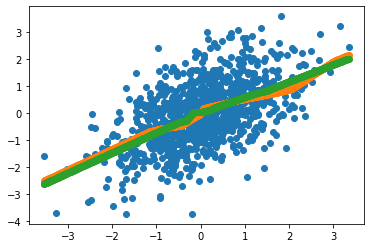

In [139]:
plt.scatter(A,B)
plt.scatter(A_test,y_pred_ones[:,1])
plt.scatter(A_test,y_pred_zeros[:,1])

In [140]:
B_strat=stratifydata(L,B)
A_test,y_ones,y_zeros=compute_third_testloss(L,A,B_strat)
print(sum(y_zeros[:,1]-y_ones[:,1])/1000)

-0.04252604985609651


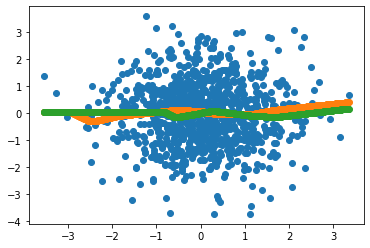

In [141]:
plt.scatter(A,B_strat)
plt.scatter(A_test,y_ones[:,1])
plt.scatter(A_test,y_zeros[:,1])

In [96]:
opt = tf.optimizers.Adam(1e-2)
mdn_PQ = MDN_module()
mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
##changing epochs didnt make much difference
mdn_PQ.fit(x=np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1),y=np.array(B_strat).T,epochs=300,batch_size=64,verbose=0)

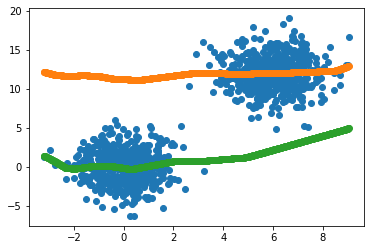

In [97]:
plt.scatter(A,B_strat)
y_pred=mdn_PQ.predict(np.concatenate([L_ones.reshape(-1,1),A.reshape(-1,1)],axis=1))
L_ones=np.ones((L.shape))
L_zeros=np.zeros((L.shape))
A_test=np.linspace(min(A),max(A),1000)
y_pred_ones= mdn_PQ.predict(np.concatenate([L_ones.reshape(-1,1),A_test.reshape(-1,1)],axis=1))
y_pred_zeros= mdn_PQ.predict(np.concatenate([L_zeros.reshape(-1,1),A_test.reshape(-1,1)],axis=1))
plt.scatter(A_test,y_pred_ones[:,1])
plt.scatter(A_test,y_pred_zeros[:,1])

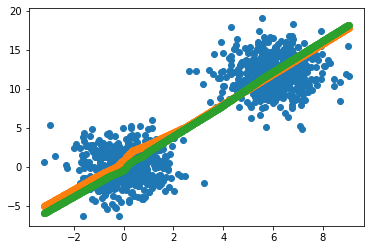

In [76]:
plt.scatter(A,B_strat)
plt.scatter(A_test,y_pred_ones[:,1])
plt.scatter(A_test,y_pred_zeros[:,1])

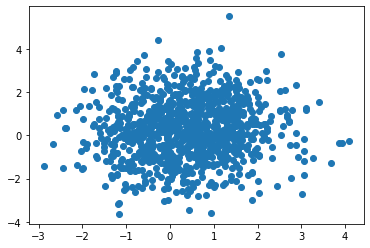

In [71]:
plt.scatter(A,stratifydata(L,B))

In [148]:
def stratify_B_n_times_diff(L,A,B,n):
    loss=[]
    indices_1 = [i for i, x in enumerate(L) if x == 1]
    #changin x==0 to x=-1
    indices_0 = [i for i, x in enumerate(L) if x == 0]
    for i in range(0,n):
        B_dist_temp=np.zeros(len(B))
        mod_indices_1=random.sample(indices_1,len(indices_1))
        for i in range(len(indices_1)):
            B_dist_temp[indices_1[i]]=B[mod_indices_1[i]]

        mod_indices_0=random.sample(indices_0,len(indices_0))
        for i in range(len(indices_0)):
            B_dist_temp[indices_0[i]]=B[mod_indices_0[i]]
        _,y_pred_ones,y_pred_zeros=compute_third_testloss(L,A,B_dist_temp)
        
        loss.append(abs(sum(y_pred_zeros[:,1]-y_pred_ones[:,1])/1000))
    return loss

In [100]:
L = np.array(np.random.binomial(1,0.5,1000))  
A=np.array(6*L+np.random.normal(0,1,1000))
B=np.array(2*A+np.random.normal(0,1,1000))

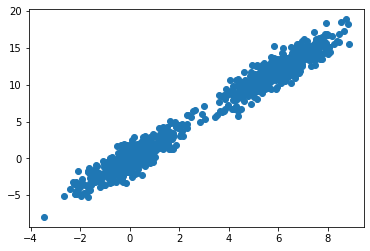

In [101]:
plt.scatter(A,B)

In [137]:
i=5
A=np.array(dataset_linear[i][1])
B=np.array(dataset_linear[i][2])
L=np.array(dataset_linear[i][0])

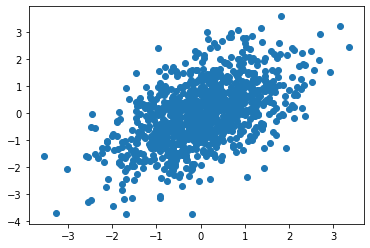

In [134]:
plt.scatter(A,B)

In [159]:
i=5
A=np.array(dataset_linear[i][1])
B=np.array(dataset_linear[i][2])
L=np.array(dataset_linear[i][0])
shuffles=10
A_shuffle=np.copy(A)
B_shuffle=np.copy(B)
#print("Original",B_shuffle)
#changed the second test from mle to using neural networks
loss_list_LA=shuffleBtimes(L,A_shuffle,shuffles,True)
loss_list_LB=shuffleBtimes(L,B_shuffle,shuffles,True)
loss_list_Bresidual=stratify_B_n_times_diff(L,A_shuffle,B_shuffle,shuffles) #conditional independence test
true_LA=compute_loss(L,A,True)
true_LB=compute_loss(L,B,True)
_,y_pred_ones,y_pred_zeros=compute_third_testloss(L,A,B)
true_LBresidual=abs(sum(y_pred_zeros[:,1]-y_pred_ones[:,1])/1000)
LA_p=calculate_pvalue(true_LA,loss_list_LA)
LB_p=calculate_pvalue(true_LB,loss_list_LB)
AB_p=calculate_pvalue(true_LBresidual,loss_list_Bresidual)

In [160]:
true_LBresidual

0.012272492207586765

In [161]:
loss_list_Bresidual

[0.07254560855031013,
 0.005018751263618469,
 0.0004775228463113308,
 0.013250523500144482,
 0.009719851326197387,
 0.1050492753237486,
 0.036689358045900004,
 0.21353161816112698,
 0.03685810978710651,
 0.19312144209071994]

In [163]:
AB_p

0.3